In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import sys

# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = [4, 4]
plt.style.use('ggplot')

In [40]:
# returns {'name': ([ratios], [throughputs])}
def to_dict(names, ratios, through_comp, through_decomp):
    res = {}
    for i, n in enumerate(names):
        if not n in res: res[n] = ([], [], [])
        res[n][0].append(ratios[i])
        res[n][1].append(through_comp[i])
        res[n][2].append(through_decomp[i])
    return res

def extract_lzbench(csv):
    results = pd.read_csv(open(csv, 'rb'))
    # first line is memcpy
    results = results[1:]
    names = [x.split()[0] for x in results['Compressor name']]
    ratios = list(results['Ratio']/100)
    through_comp = list(results['Compression speed'])
    through_decomp = list(results['Decompression speed'])
    return to_dict(names, ratios, through_comp, through_decomp)

def extract_nvcomp(csv):
    results = pd.read_csv(open(csv, 'rb'))
    results = results[1:]
    names = list(results['Compressor name'])
    ratios = list(1/results['Compression ratio'])
    through_comp = list(1000*results['Compression throughput (uncompressed) in GB/s'])
    through_decomp = list(1000*results['Decompression throughput (uncompressed) in GB/s'])
    return to_dict(names, ratios, through_comp, through_decomp)

def plot_run(results, color=None, label=None, abymachine=False):
    labeled = False
    for name in results:
        res = results[name]
        
        tooclose = name in ['culzss_hcmc']
        valign = verticalalignment = 'top' if tooclose else 'bottom'
        gpu = name in ['dietgpu', 'bsc_cuda', 'bsc', 'nvcomp_lz4',
                       'hcmc', 'culzss', 'cuda_bzip2', 'culzss_hcmc']
        gpu = gpu or 'nvcomp' in name
        nx = name == 'libnxz'
        
        alpha = 0.6
        if abymachine:
            if label=='HLT-like':
                alpha = 1
        elif gpu or nx:
            alpha = 1
        marker =  '' if len(res[0]) > 1 else '.'
        if 'bsc_cuda' in name: name = 'bsc'
        
        l = label if not labeled else None
        plt.plot(res[0], res[1], marker=marker, markersize=4, label=l, c=color, alpha=alpha)
        labeled = True
        
        if gpu: name = name + '*'
        if nx: name = name + '**'
        name = ' ' + name
                
        plt.annotate(name, (res[0][0], res[1][0]), fontsize=9, alpha=alpha, verticalalignment=valign)
        
    plt.xlabel('Compression ratio (outsize/insize)')
    plt.ylabel('Throughput (MB/s)')
    plt.yscale('log')
    plt.subplots_adjust(left=0.2, right=0.75)
    
def plot_all(fnames, colors=None, legend=True, outname=None):
    i = 0
    for fname in fnames:
        if 'nvcomp' in fname:
            res = extract_nvcomp(fname)
        else:
            res = extract_lzbench(fname)
#             res.pop('lzma')
            res.pop('bsc')
            res.pop('xz')
#             res.pop('zlib')
            p9 = 'p9' in fname
            alpha = 1
#             alpha = 0.6 if p9 else 1
            label = 'POWER9' if p9 else 'HLT-like'
            color = colors[i] if colors else None
        plot_run(res, color, label, abymachine=True)
        i += 1
        
    
    if legend:
        legend = plt.legend(bbox_to_anchor=(1.05, 0.6), loc="upper left")
        frame = legend.get_frame()
#         frame.set_facecolor('white')
        frame.set_edgecolor('white')
    if outname:
        plt.savefig(outname, dpi=300)
    else:
        plt.show()

In [27]:
compcolors = {
    'bsc': 'darkred',
    'dietgpu': 'darkblue',
    'libnxz': 'purple',
    'nvcomp_lz4': 'darkgreen',
    'lz4': 'lightblue',
    'zlib': 'goldenrod',
    'zstd': 'blue',
    'xz': 'red',
#     'bsc': '#ff6961',
#     'dietgpu': '#ffb480',
#     'libnxz': '#f8f38d',
#     'nvcomp_lz4': '#42d6a4',
#     'lz4': '#08cad1',
#     'zlib': '#59adf6',
#     'zstd': '#9d94ff',
#     'xz': '#c780e8',
}

fnames_pp = [
    'results/hlt-pp.csv',
    'results/p9-pp.csv',
#     'results/old/nvcomp.csv',
    ]
fnames_hi = [
    'results/hlt-hi.csv',
    'results/p9-hi.csv',
    ]
cmap = matplotlib.cm.get_cmap('inferno')
# colors = [cmap(0.3), cmap(0.5), cmap(0.5), cmap(0.6)]
colors = ['mediumslateblue', 'crimson']
colors_pp = colors
colors_hi = colors

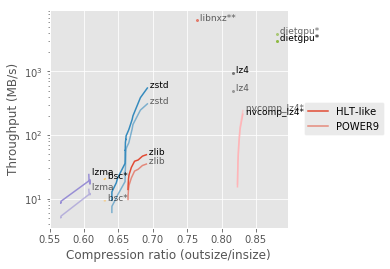

In [28]:
# plot_all(fnames_pp, legend=False, outname='results/combined-pp-nolegend.png')
# plot_all(fnames_pp, legend=True, outname='results/combined-pp.png')
# plot_all(fnames_pp, legend=False)
plot_all(fnames_pp, legend=True)

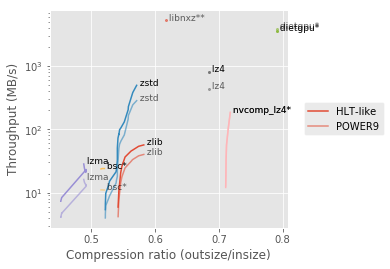

In [31]:
# plot_all(fnames_hi, legend=False, outname='results/combined-hi-nolegend.png')
# plot_all(fnames_hi, legend=True, outname='results/combined-hi.png')
# plot_all(fnames_hi, legend=False)
plot_all(fnames_hi, legend=True)

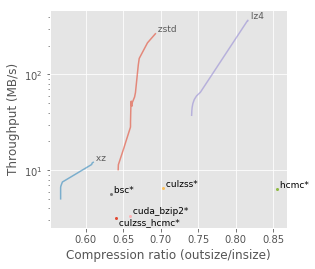

In [41]:
# cres = {'zstd': [['-1', '-3', '-9', '-19'], [258.4140463296379, 163.88852924781074, 43.72637526427399, 9.687707828359505], [0.7933601455488924, 0.7782279396745265, 0.7702009160626969, 0.756965973429537]], 'xz': [['-0', '-3', '-6', '-9'], [11.606166096022688, 9.458649823623368, 5.100490349702948, 4.885381564136004], [0.6994451579373356, 0.6877364378594628, 0.646091372563434, 0.646091372563434]], 'bsc_cuda': [['-G -m5 -e0', '-G -m5 -e1', '-G -m5 -e2'], [10.621215693845622, 9.186427734113185, 6.122815660623057], [0.7569990726725884, 0.7499531398838015, 0.743792291826334]], 'culzss': [[''], [17.34874110339761], [1.1181232253731117]], 'hcmc': [[''], [16.585734771547497], [0.9126902314990318]], 'cuda_bzip2': [[''], [6.499193246661601], [0.766410046955208]]}
cres = {'zstd': [['-1', '-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19'], [265.1168863805326, 213.2218750789495, 146.63156004957307, 124.88265119903679, 64.61258813150278, 58.092479937278256, 50.911700893386815, 46.62234748176323, 47.993565518414215, 51.77122668652963, 52.644537507362664, 46.111204164562494, 32.26678781838978, 29.366467693708685, 28.221871909384888, 19.68615286529393, 16.741789957072594, 11.434213286835133, 10.164591217717609], [0.6929520935468456, 0.6824044743995479, 0.671395301702633, 0.6701425836208659, 0.6663907824792864, 0.6652033896505323, 0.6622027217170289, 0.6617005895510988, 0.66081788051816, 0.6608110196175154, 0.6608096711345762, 0.660278667892496, 0.6597973948957133, 0.6597962833846714, 0.6597559191715038, 0.6533810027506457, 0.6505736136103026, 0.6435946558233141, 0.6433554270508364]], 'xz': [['-1', '-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9'], [12.129677680655284, 11.897628928478277, 11.49567826148207, 7.550822845996891, 6.840386484706303, 6.602128252252854, 5.791088890477626, 5.066291140235172, 5.0426202429915215], [0.6100460534570459, 0.6085839594196685, 0.6079745354061573, 0.568942939345023, 0.5668987746217046, 0.5665953603181959, 0.5665953603181959, 0.5665953603181959, 0.5665953603181959]], 'lz4': [['-1', '-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9'], [362.991086825574, 366.73682489821783, 65.04374546080719, 59.73623212829365, 54.687746769703175, 49.744272367785044, 45.28727937820793, 41.95069858970876, 37.4816158720405], [0.8161593517748851, 0.8161593517748851, 0.7529349731171745, 0.7479090587168177, 0.744828000888261, 0.7429557874873489, 0.7419790908862042, 0.7415689602382936, 0.741291020413741]], 'bsc': [['-G -b1 -m6 -cf -e0 -H15 -M4'], [5.63487850812791], [0.6337076409771489]], 'culzss': [[''], [6.504671267964982], [0.7034461908984895]], 'hcmc': [[''], [6.316128724632139], [0.8546363997432894]], 'cuda_bzip2': [[''], [3.3720181191825915], [0.6588014132958815]]}
cres.update({'culzss_hcmc': [[''], [3.1902761455152744], [0.6404584456067628]]})
for n in cres:
    r = cres[n]
    cres[n] = [r[2], r[1]]
    
plot_run(cres)
plt.savefig('results/firstish.png', dpi=300)